# User interface Node #
This node will create a user interface for the Bug0 robot, in it the user will be able to set a new goal, delete the current one or get infromations about the number of goal reached or deleted.

### Libraries and global variables: ###
In this first cell a series of libraries needed for the User interface are imported and the global variables are istantiated.

In [1]:
#! /usr/bin/env python3

%matplotlib widget
import rospy
import time
import sys
import select
import os
import actionlib
import actionlib.msg
import assignment_2_2022.msg
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from assignment_2_2022.srv import Ngoal
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Layout
import logging
from IPython.display import display
import jupyros as jr
import numpy as np
import matplotlib.pyplot as plt

act_clnt = None # istantiate the action client 
goal = assignment_2_2022.msg.PlanningGoal() # istantiate the goal message to send 
goal.target_pose.pose.position.z = 0.0 # set its third component equal to 0
info = Ngoal() # istantiate the info request for the service (number of goal reached and deleted)
srv_info = None # istantiate the responce
gf = 0 # goal flag to increase the number of goal only the first time the state pass to succeeded
pr_goalx = [] # array to store the x position of the goal
pr_goaly = [] # array to store the y position of the goal
x = [] # array to store the last 30 x position of the robot
y = [] # array to store the last 30 y position of the robot
i = 0 # counter for fulfill the array of the position in odom_cb
ax = None # istantiate the graph (robot)
count_odom = 0 # counter used to optimize the odom callback
count_scan = 0 # counter used to optimize the scan callback

### graph_view function: ###
This function will plot a graph as a representation of the world, in it the recent position history of the robot and the goal position will be represented, respectively in a blue line and in red stars.

In [2]:
def graph_view():
    global ax, x, y
    
    np_x_plot = np.array(x) # conver the x array that store the position of the robot in numpy format
    np_y_plot = np.array(y) # conver the y array that store the position of the robot in numpy format
    fig = plt.figure("world representation") # create a figure titled world representation
    ax = fig.add_axes([0, 0, 1, 1]) # add the x and y axes
    ax.set_xlim((-10, 10)) # give a dimensional limit along x (the size of the map)
    ax.set_ylim((-10, 10)) # give a dimensional limit along y (the size of the map)
    ax.set_xlabel("x") # name the axes x
    ax.set_ylabel("y") # name the axes y
    ax.plot(np_x_plot, np_y_plot, '-', color = 'b') # plot the already converted position of the robot in blue

### D_cb function: ###
This is the callback of the D button, used to delete the current goal, once the button is pressed it will check if there is an active goal, will delete it, will recover the actual number of goal deleted from the ros parameter server, increase it and then set it back in the ros parameter server.

In [3]:
def D_cb(b):
    if ((act_clnt.get_state()) == 1): # in this case there is an active goal
        act_clnt.cancel_goal() # delete the goal
        n_deleted = rospy.get_param('n_deleted') # get the actual number of goal deleted
        n_deleted = n_deleted + 1 # increase it
        rospy.set_param('n_deleted', n_deleted) # load it in the paramserver

### N_cb function: ###
This is the callback of the N button, used to set a new goal, once pressed it will first check that the user finished to insert the previous goal, done that it activate the texts boxes to put the coordinate of the goal and deactivate itself.  

In [4]:
def N_cb(b):
    if ((Gx.disabled == True) and (Gy.disabled == True)): # check if the previous goal insertion is finished
        Gx.disabled = False # unlock the x goal text box
        Gy.disabled = False # unlock the y goal text box
        N.disabled = True # lock the N button till the insertion of the goal is finshed

### I_cb function: ###
This is the callback of the I button, used to obtain information about the number of goal reached and deleted, it will first call the service srv_info, provided by an external node, obtained the data from it it will set the two value of the text boxes with the relative value.

In [5]:
def I_cb(b):
    info = srv_info() # obtain the number of goal reached and deleted
    Gr.value = info.n_goal # set the number of goal reached in the right text box
    Gd.value = info.n_deleted # set the number of goal deleted in the right text box

### II function: ###
This function will create and display the user interface part in which the previous goal will be listed, in detail if it's the first time it's called it will create the text boxes with the titles 'Goal list', 'x_goal', 'y_goal', and will group them in one single widget called 'Gl' and display it; then in all the cases it will create the float Text boxes in which the coordinates of the goals will be displayed, combine them in one single widget under the name 'Gl2' and then display them.
Moreover, since this function will be called right after the declaration of a new goal, it will plot again the goals to update them.

In [6]:
def II():
    global ax
        
    # if it's the first time the function is called:
    if (len(pr_goalx) == 1):
        
        # info box for the goal list:
        # name:
        Gl_n = widgets.Text(value = 'Goal list', disabled = True, layout = L3)
        Glx_n = widgets.Text(value = 'x_goal', disabled = True, layout = L2)
        Gly_n = widgets.Text(value = 'y_goal', disabled = True, layout = L2)
        # group everything together:
        Gl1 = HBox([Glx_n, Gly_n])
        Gl = VBox([Gl_n, Gl1])
        # display:
        display(Gl)
               
    # data:
    Glx = widgets.FloatText(value = pr_goalx[len(pr_goalx) - 1], disabled = True, layout = L2, continuous_update = True)
    Gly = widgets.FloatText(value = pr_goaly[len(pr_goaly) - 1], disabled = True, layout = L2, continuous_update = True)
    
    # combination:
    Gl2 = HBox([Glx, Gly])
    
    # connect to the already done menu:
    display(Gl2)
    
    # plot the updated goals:
    np_Gx_plot = np.array(pr_goalx)
    np_Gy_plot = np.array(pr_goaly)
    ax.plot(np_Gx_plot, np_Gy_plot, '*', color='r') # plot them as a red star

### NGx_cb function: ###
This is the callback of the text box in which the x coordinate of the goal will be set, it will be called once the user press enter or, once written something different from the previous value, when it click away from it.
the function will first disable the text box, meaning the user will no longer be able to type anything in it, then it will set the x coordinate in the goal message that then will be send to the action server.
done that the function will check if the user as putted also the other coordinate, and if so it will enable again the N button, send the goal, record the new goal in the internal array 'pr_goalx' and 'pr_goaly' and call the 'II()' function.

In [7]:
def NGx_cb(value):   
    Gx.disabled = True # disable text box
    goal.target_pose.pose.position.x = float(Gx.value) # set the x coordinates of the goal
    if (Gy.disabled): # if the user has already set the other coordinate
        N.disabled = False # enable again the N button
        act_clnt.send_goal(goal) # send the goal
        pr_goalx.append(Gx.value) # store the x coordinate of the goal internally
        pr_goaly.append(Gy.value) # store the y coordinate of the goal internally
        II() # call the II() function

### NGy_cb function: ###
This is the callback of the text box in which the y coordinate of the goal will be set, it will work exactly as the 'NGy_cb' function.

In [8]:
def NGy_cb(value):    
    Gy.disabled = True # disable text box
    goal.target_pose.pose.position.y = float(Gy.value) # set the x coordinates of the goal
    if (Gx.disabled): # if the user has already set the other coordinate
        N.disabled = False # enable again the N button
        act_clnt.send_goal(goal) # send the goal
        pr_goalx.append(Gx.value) # store the x coordinate of the goal internally
        pr_goaly.append(Gy.value) # store the y coordinate of the goal internally
        II() # call the II() function

### User interface: ###
This cell will create the user interface that the user will use to control the behavior of the robot, in detail it will display three buttons, one for deleting the goal 'D', one for set a new goal 'N' and the relative text boxes with the title to insert the coordinates and one last button 'I' to recover the number of goal reached and deleted and display those information in two text boxes with the relative labels.
More over this cell will call the 'graph_view()' function to display the world representation, display the above mentioned user interface and create the callback for the buttons and text boxes.

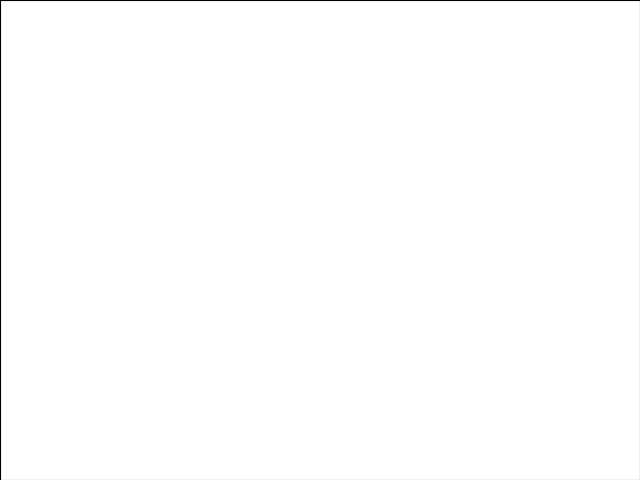

In [9]:
# different layout:
L1 = Layout(width = 'auto', height = '10%', min_width = '80px', min_height = '54px', max_width = '160px') 
L2 = Layout(width = 'auto', height = '5%', min_width = '40px', min_height = '20px', max_width = '80px')
L3 = Layout(width = 'auto', height = '5%', min_width = '80px', min_height = '20px', max_width = '160px')

# delete goal button:
D = widgets.Button(value = False, description = 'Delete Goal', disabled = False, button_style = 'danger', layout = L1, continuous_update = False)

# new goal button:
N = widgets.Button(value = False, description = 'New Goal', disabled = False, button_style = 'success', layout = L1, continuous_update = False)

# information button:
I = widgets.Button(value = False, description = 'Information', disabled = False, button_style = 'info', layout = L1, continuous_update = False)


# info box for the goal coordinates:
# name:
Gx_n = widgets.Text(value = 'x_goal', disabled = True, layout = L2)
Gy_n = widgets.Text(value = 'y_goal', disabled = True, layout = L2)
# data:
Gx = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = False)
Gy = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = False)
# combination:
Gx_c = VBox([Gx_n, Gx])
Gy_c = VBox([Gy_n, Gy])
Gxy = HBox([Gx_c, Gy_c])

# info box for the goal reached and deleted:
# name:
Gr_n = widgets.Text(value = 'goal_r', disabled = True, layout = L2)
Gd_n = widgets.Text(value = 'goal_d', disabled = True, layout = L2)
# data:
Gr = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = False)
Gd = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = False)
# combination:
Gr_c = VBox([Gr_n, Gr])
Gd_c = VBox([Gd_n, Gd])
Grd = HBox([Gr_c, Gd_c])

# combine everything
UI = VBox([D, HBox([N, Gxy]), HBox([I, Grd])])

# info box for the robot position:
# name:
Rp_n = widgets.Text(value = 'robot position', disabled = True, layout = L3)
Rpx_n = widgets.Text(value = 'x_robot', disabled = True, layout = L2)
Rpy_n = widgets.Text(value = 'y_robot', disabled = True, layout = L2)
# data:
Rpx = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = True)
Rpy = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = True)
# combination:
Rpx_c = VBox([Rpx_n, Rpx])
Rpy_c = VBox([Rpy_n, Rpy])
Rpxy_c = HBox([Rpx_c, Rpy_c])
Rpxy = VBox([Rp_n, Rpxy_c])

# info box for the closer obstacle:
# name:
Co_n = widgets.Text(value = 'closer obstacle', disabled = True, layout = L3)
Cod_n = widgets.Text(value = 'dist', disabled = True, layout = L2)
Coa_n = widgets.Text(value = 'angle', disabled = True, layout = L2)
# data:
Cod = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = True)
Coa = widgets.FloatText(value = '0.00', disabled = True, layout = L2, continuous_update = True)
# combination:
Cod_c = VBox([Cod_n, Cod])
Coa_c = VBox([Coa_n, Coa])
Coda_c = HBox([Cod_c, Coa_c])
Coda = VBox([Co_n, Coda_c])

# combine everything
IM = VBox([Rpxy, Coda])

# combine UI and IM and print:
CUI = HBox([UI, IM])

# plot
graph_view()

display(CUI)

# callbacks:
D.on_click(D_cb)
N.on_click(N_cb)
Gx.observe(NGx_cb, names = 'value')
Gy.observe(NGy_cb, names = 'value')
I.on_click(I_cb)

### odom_cb function: ###
This is the callback of the '/odom' subscriber, each time a new position of the robot is published this function will be called, in detail one time over ten it will write the position of the robot on the related text box, reset the counter and add the position of the robot in the array 'x', 'y', the array is limited to 30 position in such a way of optimizing the visualization, and plot them; done that in all the cases the function will increase the counter and check if the goal has been reached, and it's the first time the check respond with a true thanks to the flag 'gf', if it's the case it will get the number of reached goals from the ros parameter server, increase it and set it back. 

In [10]:
def odom_cb(msg):
    global Rpx, Rpy, act_clnt, gf, x, y, i, ax, count_odom
    
    if (count_odom == 10): # once over ten times
        # get position valeu and display them in the text window:
        Rpx.value = round(msg.pose.pose.position.x, 2)
        Rpy.value = round(msg.pose.pose.position.y, 2)
        count_odom = -1
    
        # add the same data in the position stored:
        if (len(x) < 30):
            x.append(round(msg.pose.pose.position.x, 2))
            y.append(round(msg.pose.pose.position.y, 2))
        else:
            x[i] = round(msg.pose.pose.position.x, 2)
            y[i] = round(msg.pose.pose.position.y, 2)
            i += 1
            
            if (i == 30):
                i = 0
        # plot:
        np_x_plot = np.array(x)
        np_y_plot = np.array(y)
        ax.plot(np_x_plot, np_y_plot, '-', color = 'b')  
    
    count_odom += 1 
    
    if (act_clnt.get_state() == 3 and gf == 0): # if i've reached the goal
        n_goal = rospy.get_param('n_goal') # get the actual number of goal
        n_goal = n_goal + 1 # increase it
        rospy.set_param('n_goal', n_goal) # load it in the paramserver
        gf = 1
    elif (act_clnt.get_state() != 3):
        gf = 0    
    

### scan_cb function: ###
This is the callback of the '/scan' subscriber, each time a new scan detection is acquired this method will be called, in detail one time over fifty the distance to the closer obstacle and the angle to it will be displayed in the relative text box. (note the Lidar of the robot scan the space in front of the robot in 720 partitions, the formula used below move the result in degree between -90 and 90)

In [11]:
def scan_cb(msg):
    global count_scan
    
    if (count_scan == 50): # one time over fifty
        Cod.value = round(min(msg.ranges), 2) # set the distance to the closer obstacle in the text box
        Coa.value = ((msg.ranges.index(min(msg.ranges)) + 1) / 4) - 90 # set the angle to it
        count_scan = -1 # reset the counter
    
    count_scan += 1 # increase the counter

### Node cell: ###
This cell will create the actual node, initially it will initialize it, then will create an action client and wait for its existence, done that the node will subscribe to the '/odom' topic, to get the position of the robot, and the 'scan' topic to get the Lidar data.
Done that it will connect as service client to the service '/info' which will return the number of goal reached and deleted, wait for its existence and then initialize the parameters of the number of goals reached and deleted to zero.

In [12]:
rospy.init_node('user_interface', anonymous=True) # init the node
act_clnt = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction) # connect to the action server
act_clnt.wait_for_server() # wait for the action server existence
sub_odom = jr.subscribe('/odom', Odometry, odom_cb) # subscribe to the /odom topic
sud_scan = jr.subscribe('/scan',LaserScan, scan_cb) # subscribe to the /scan topic
srv_info = rospy.ServiceProxy("/info", Ngoal) # connect to the service server
rospy.wait_for_service("/info") # wait for the service server existance
rospy.set_param('n_goal', 0) # init the param n_goal (reached)
rospy.set_param('n_deleted', 0) # init the param n_deleted